# **Project: Document Scanning for Book Pages**

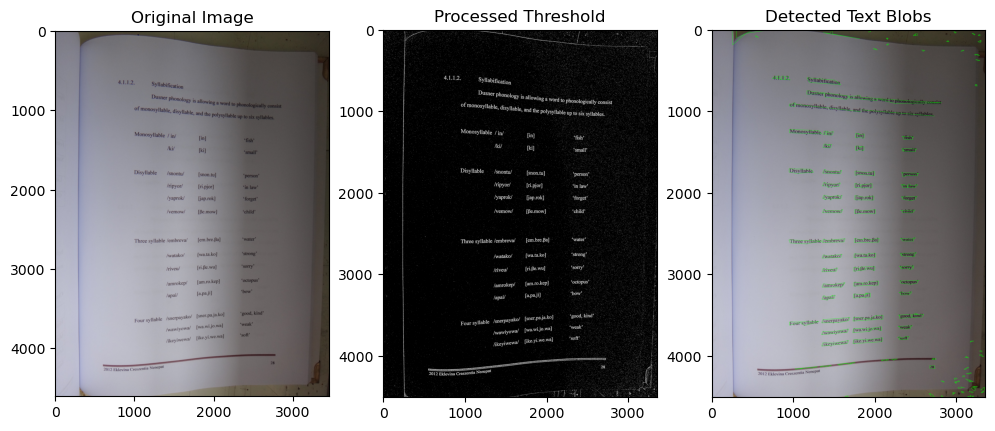

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def detect_text_blobs(image_path):
    # Step 1: Load and Preprocess Image
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    height, width = gray.shape

    # Step 2: Carve Out Middle Hunk of the Image 
    margin = 50  
    cropped = gray[margin:height-margin, margin:width-margin]

    # Step 3: Gaussian Blur to Reduce Noise
    blurred = cv2.GaussianBlur(cropped, (5, 5), 0)

    # Step 4: Adaptive Thresholding
    thresh = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2)

    # Step 5: Morphological Dilation (Horizontal Box)
    kernel_horiz = cv2.getStructuringElement(cv2.MORPH_RECT, (25, 1))
    dilated = cv2.dilate(thresh, kernel_horiz, iterations=1)

    # Step 6: Morphological Erosion (Vertical Box)
    kernel_vert = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 8))
    eroded = cv2.erode(dilated, kernel_vert, iterations=1)

    # Step 7: Connected Component Analysis
    contours, _ = cv2.findContours(eroded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Filter and Approximate Contours
    filtered_contours = []
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        aspect_ratio = w / float(h)
        area = cv2.contourArea(contour)
        if 1.5 < aspect_ratio < 10 and h > 15 and area > 50:  
            approx = cv2.approxPolyDP(contour, 0.02 * cv2.arcLength(contour, True), True)
            filtered_contours.append(approx)

    # Step 8: Draw Contours on Original Image
    output_image = image[margin:height-margin, margin:width-margin].copy()
    for contour in filtered_contours:
        cv2.drawContours(output_image, [contour], -1, (0, 255, 0), 2)

    # Visualize Results
    plt.figure(figsize=(12, 8))
    plt.subplot(1, 3, 1)
    plt.title("Original Image")
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    
    plt.subplot(1, 3, 2)
    plt.title("Processed Threshold")
    plt.imshow(thresh, cmap='gray')
    
    plt.subplot(1, 3, 3)
    plt.title("Detected Text Blobs")
    plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
    plt.show()

# Example usage
detect_text_blobs("linguistics_thesis_a.jpg")
